# Dynamic KSS Figure Generation

This notebook generates publication-quality figures showing K-mer Significance Score (KSS),
discriminative score, and mutational score for viral genomes.

**Features:**
- Automatically extracts top 5 KSS positions for COVID-19 and HIV-1
- Gene-specific figures for HCMV (UL55, UL73, US28)
- Dynamic loading from compiled_results.json files
- Interactive visualization in notebook environment

**Author:** KSS Project
**Date:** 2026-01-20

## 1. Imports and Configuration

In [1]:
import os
import re
import sys
import json
import time
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as path_effects
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, Border, Side, PatternFill
from openpyxl.utils import get_column_letter

# Add parent directory to path for imports
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Enable inline plotting for notebook
%matplotlib inline

## 2. Configuration Classes

In [2]:
class Config:
    """Configuration for data paths and processing"""
    BASE_DIR = os.path.dirname(os.getcwd())
    DATA_DIR = os.path.join(BASE_DIR, "data")

    VIRAL_DATASETS = {
        "Severe_acute_respiratory_syndrome_coronavirus_2": {
            "genes": ["ORF1ab", "S", "M", "N", "E"],
            "top_n": 12,
            "max_indels": 3,  # Maximum number of positions with indels in top N
            "genotype_field": None,
        },
        "Human_immunodeficiency_virus_1": {
            "genes": ["gag", "pol", "env"],
            "top_n": 12,
            "max_indels": 3,  # Maximum number of positions with indels in top N
            "genotype_field": None,
        },
        "Human_betaherpesvirus_5": {
            "genes": ["UL55", "UL73", "US28"],
            "top_n": 10,
            "max_indels": 3,  # Maximum number of positions with indels in top N
            "genotype_field": "class_counts",
        },
    }


class StyleConfig:
    """Configuration for all styling parameters"""
    TITLE_SIZE = 20
    AXIS_LABEL_SIZE = 11
    TICK_SIZE = 8
    GENE_NAME_SIZE = 12
    LEGEND_SIZE = 12
    HIGHLIGHT_SIZE = 8

    GENE_BORDER = 0.8
    CURVE_WIDTH = 1
    SHADOW_WIDTH = 1.5

    SCATTER_ALPHA = 0.85
    CURVE_ALPHA = 0.85
    SHADOW_ALPHA = 0.15
    GENE_ALPHA = 0.5

    SCATTER_SIZE = 20
    GENE_HEIGHT = 1.35
    BOTTOM_MARGIN = 1.6
    TOP_MARGIN = 0.3
    HIGHLIGHT_MARKER_SIZE = 50

    FIGURE_DPI = 300
    EXPORT_DPI = 600

    INDEL_DISTINCTION = True   # True = visually distinguish indel vs substitution boxes
    


# Color scheme
COLORS = {
    'gene': "#E8E8E8",
    'kmer': "#2166AC",
    'discriminative': "#D6604D",
    'mutational': "#4DAF4A",
    'highlight': "#666666",
}

# Virus name mapping
VIRUS_NAMES = {
    "Severe_acute_respiratory_syndrome_coronavirus_2": "SARS-CoV-2",
    "Human_immunodeficiency_virus_1": "HIV-1",
    "Human_betaherpesvirus_5": "HCMV"
}

# Manual annotation positions configuration
ANNOTATION_CONFIG = {
    "auto": False,

    "manual_positions": {
        "Severe_acute_respiratory_syndrome_coronavirus_2": [
            # --- S gene (9 positions) ---
            {"position": 21617, "annotation_x": 19411 , "annotation_y": 1.10},                         # KSS 0.816 T19I/R
            {"position": 21761, "annotation_x": 19411 - 404, "annotation_y": 1.40, "zorder": 15},      # KSS 0.957 H69-/A67V
            {"position": 21986, "annotation_x": 19411 + 216, "annotation_y": 1.70},                    # KSS 0.987 Y144-/G142D/V143-
            {"position": 22193, "annotation_x": 22200 - 682, "annotation_y": 1.40},                    # KSS 0.969 N211-/L212I/V213G
            {"position": 22670, "annotation_x": 22670 + 1096, "annotation_y": 1.40 , "zorder": 15},    # KSS 0.812 S371L/F
            {"position": 22679, "annotation_x": 22679 - 0, "annotation_y": 1.70, "zorder": 15},        # KSS 0.779 S373P/S375F
            {"position": 23012, "annotation_x": 23012 + 2264, "annotation_y": 1.70},                   # KSS 0.832 E484A/K/Q | F486V/S/P
            {"position": 23597, "annotation_x": 23597 + 2000, "annotation_y": 1.40},                   # KSS 0.785 P681H/R | N679K
            {"position": 23948, "annotation_x": 23948 + 2220, "annotation_y": 1.10},                   # KSS 0.806 D796Y
            # --- ORF1ab gene (1 position) ---
            {"position": 17411, "annotation_x": 17411, "annotation_y": 1.10},                          # KSS 0.872 R5716C
            # --- N gene (2 positions) ---
            {"position": 28976, "annotation_x": 28976 + 705, "annotation_y": 1.10},                    # KSS 0.793 S235F
            {"position": 28877, "annotation_x": 28877 - 368, "annotation_y": 1.40},                    # KSS 0.785 R203K/G204R
        ],

        "Human_immunodeficiency_virus_1": [

            # --- gag gene (4 positions) ---
            {"position":  651, "annotation_x":  651, "annotation_y": 1.40},         # KSS 0.894 E107I
            {"position":  714, "annotation_x":  714, "annotation_y": 1.10},         # KSS 0.939 Q127-/V128-
            {"position": 1713, "annotation_x": 1713 - 292, "annotation_y": 1.40},   # KSS 0.849 E460A
            {"position": 1722, "annotation_x": 1722 + 736, "annotation_y": 1.70, "zorder": 5},   # KSS 0.952 S465-
            # --- pol gene (7 positions) ---
            {"position": 1640, "annotation_x": 1640 - 332, "annotation_y": 1.10},                  # KSS 0.829 D5N/D5I
            {"position": 1730, "annotation_x": 1730 - 375, "annotation_y": 1.70, "zorder": 10},   # KSS 0.970 W34-/G35-
            {"position": 1856, "annotation_x": 1856 + 428, "annotation_y": 1.10},                  # KSS 0.942 K76I
            {"position": 2612, "annotation_x": 2612, "annotation_y": 1.40, "zorder": 15},                  # KSS 0.849 K328S
            {"position": 2702, "annotation_x": 2702, "annotation_y": 1.10},                  # KSS 0.874 E359L/Syn
            {"position": 3755, "annotation_x": 3755, "annotation_y": 1.40}, # KSS 0.850 A709S/N/K
            {"position": 4178, "annotation_x": 4178, "annotation_y": 1.10}, # KSS 0.830 K851Q
            # --- env gene (1 position) ---
            {"position": 6581, "annotation_x": 6581, "annotation_y": 1.10}, # KSS 0.818 V271I/M/R
        ],

        "Human_betaherpesvirus_5": {
            "UL55": [
                {"position": 81457, "annotation_x": 81457, "annotation_y": 1.40, "zorder": 15},             # KSS 0.841 G51-/V/I
                {"position": 81502, "annotation_x": 81502 + 95, "annotation_y": 0.80},                      # KSS 0.616 G66R
                {"position": 81853, "annotation_x": 81853, "annotation_y": 1.10},                           # KSS 0.664 S181K/R
                {"position": 82654, "annotation_x": 82654 - 165, "annotation_y": 1.10},                     # KSS 0.674 R448S
                {"position": 82663, "annotation_x": 82663 - 170, "annotation_y": 1.40, "zorder": 15},       # KSS 0.647 L453I/S
                {"position": 82672, "annotation_x": 82672 - 114, "annotation_y": 1.70, "zorder": 10},       # KSS 0.857 N456-
                {"position": 82699, "annotation_x": 82699 + 580, "annotation_y": 1.70},                     # KSS 0.857 D463-
                {"position": 82717, "annotation_x": 82717 + 612, "annotation_y": 1.40},                     # KSS 0.664 H469L | L470S
                {"position": 82726, "annotation_x": 82726 + 560, "annotation_y": 1.10},                     # KSS 0.697 N472S | M473S
                {"position": 82735, "annotation_x": 82735 + 798, "annotation_y": 0.80},                     # KSS 0.618 H477R
            ],
            "UL73": [
                {"position": 106701, "annotation_x": 106701, "annotation_y": 1.40},                         # KSS 0.605 N4K | L6R/V
                {"position": 106737, "annotation_x": 106737, "annotation_y": 1.70},                         # KSS 0.794 E18-
                {"position": 106782, "annotation_x": 106782, "annotation_y": 1.10},                         # KSS 0.794 S33-/T31S
                {"position": 106791, "annotation_x": 106791 + 55, "annotation_y": 1.40},                    # KSS 0.787 K34S/P
                {"position": 106800, "annotation_x": 106800 + 110, "annotation_y": 1.70},                   # KSS 0.712 A37H/T/R/S


                
                
                {"position": 106818, "annotation_x": 106818 + 50, "annotation_y": 1.10, "zorder": 10},# KSS 0.605 L44A/S/P
                {"position": 106827, "annotation_x": 106827 + 200, "annotation_y": 1.70},               # KSS 0.596 V47T/S

                {"position": 106854, "annotation_x": 106854 + 200, "annotation_y": 1.40},                # KSS 0.643 T55V | T56A/M/R
                

                {"position": 106872, "annotation_x": 106872 + 200, "annotation_y": 1.10},               # KSS 0.572 S61T | T62L
                {"position": 106926, "annotation_x": 106926 + 145, "annotation_y": 0.80},               # KSS 0.575 R79P
            ],
            "US28": [
                # Unchanged — 0 indels, same top 10
                {"position": 221694, "annotation_x": 221694 + 245, "annotation_y": 1.65},
                {"position": 221685, "annotation_x": 221685 + 150, "annotation_y": 1.40, "zorder": 35},
                {"position": 222621, "annotation_x": 222621, "annotation_y": 1.20},
                {"position": 221703, "annotation_x": 221703 + 285, "annotation_y": 1.40},
                {"position": 221739, "annotation_x": 221739 + 302, "annotation_y": 0.90},
                {"position": 221712, "annotation_x": 221712 + 275, "annotation_y": 1.15},
                {"position": 221766, "annotation_x": 221766 + 275, "annotation_y": 0.65},
                {"position": 221640, "annotation_x": 221640, "annotation_y": 1.65},
                {"position": 221676, "annotation_x": 221676, "annotation_y": 1.40},
                {"position": 222432, "annotation_x": 222432, "annotation_y": 1.20},
            ],
        },
    }
}

print(f"Configuration loaded successfully")
print(f"Data directory: {Config.DATA_DIR}")
print(f"Viruses configured: {list(Config.VIRAL_DATASETS.keys())}")

Configuration loaded successfully
Data directory: c:\Users\lebat\Documents\Projects\KSS\data
Viruses configured: ['Severe_acute_respiratory_syndrome_coronavirus_2', 'Human_immunodeficiency_virus_1', 'Human_betaherpesvirus_5']


## 3. Data Loading Functions

In [3]:

# Global cache for class totals to avoid reloading uncompiled files
_CLASS_TOTALS_CACHE = {}


def load_compiled_results(virus_name, gene_name):
    """Load compiled results JSON for a specific gene"""
    results_path = os.path.join(
        Config.DATA_DIR,
        virus_name,
        gene_name,
        "results",
        f"{gene_name}_compiled_results.json"
    )

    if not os.path.exists(results_path):
        print(f"Warning: Results file not found: {results_path}")
        return None

    print(f"   Loading compiled results for {gene_name}...", end=" ", flush=True)
    start_time = time.time()

    with open(results_path, 'r') as f:
        data = json.load(f)

    elapsed = time.time() - start_time
    print(f"✓ ({elapsed:.2f}s)")

    return data.get(gene_name, {})


def load_uncompiled_results(virus_name, gene_name):
    """Load uncompiled results JSON for detailed per-sequence information"""
    results_path = os.path.join(
        Config.DATA_DIR,
        virus_name,
        gene_name,
        "results",
        f"{gene_name}_results.json"
    )

    if not os.path.exists(results_path):
        return None

    print(f"   Loading uncompiled results for {gene_name}...", end=" ", flush=True)
    start_time = time.time()

    with open(results_path, 'r') as f:
        data = json.load(f)

    elapsed = time.time() - start_time
    print(f"✓ ({elapsed:.2f}s)")

    return data.get("genes", {}).get(gene_name, {})


def load_genbank_file(virus_name, gene_name):
    """Load GenBank file to extract CDS coordinates"""
    gene_dir = os.path.join(Config.DATA_DIR, virus_name, gene_name)

    if not os.path.exists(gene_dir):
        print(f"Warning: Gene directory not found: {gene_dir}")
        return None

    genbank_files = [f for f in os.listdir(gene_dir) if f.lower().endswith('.gb')]

    if not genbank_files:
        print(f"Warning: No GenBank file found in {gene_dir}")
        return None

    genbank_path = os.path.join(gene_dir, genbank_files[0])
    record = list(SeqIO.parse(genbank_path, "genbank"))[0]

    # Find CDS feature for this gene
    cds_candidates = []
    for feature in record.features:
        if feature.type == "CDS":
            # Check if gene qualifier matches
            if "gene" in feature.qualifiers:
                if feature.qualifiers["gene"][0] == gene_name:
                    print(f"  Found CDS for {gene_name}: positions {int(feature.location.start)}..{int(feature.location.end)}")
                    return {
                        "start": int(feature.location.start),
                        "end": int(feature.location.end),
                        "record": record
                    }
            cds_candidates.append(feature)

    # If no exact match, take the largest CDS
    if cds_candidates:
        largest_cds = max(cds_candidates, key=lambda f: len(f.location))
        print(f"  No exact gene match found. Using largest CDS: positions {int(largest_cds.location.start)}..{int(largest_cds.location.end)}")
        return {
            "start": int(largest_cds.location.start),
            "end": int(largest_cds.location.end),
            "record": record
        }

    print(f"Warning: No CDS found for {gene_name} in {genbank_path}")
    return None

def has_indel(aa_change):
    """Check if an amino acid change is an indel (insertion/deletion)"""
    return '-' in aa_change


def extract_position_number(aa_change):
    """Extract numeric position from amino acid change (e.g. Y144- -> 144)"""
    match = re.search(r'\d+', aa_change)
    return int(match.group()) if match else 0

def group_mutations_compact(sorted_mutations):
    """Group mutations by amino acid position for compact figure labels.

    Input:  sorted list of (aa_change_str, score) — already sorted by position.
    Output: compact string like "ΔY144- | E484A/K/Q | F486V/S/P"

    Rules:
      - Same position  → slash-separated new AAs  (E484A/K/Q)
      - Different positions → pipe-separated       (E484A/K/Q | F486V/S/P)
      - Indels (contains '-') get Δ prefix per group
      - Synonymous (empty list) returns "Synonymous"
    """
    import re
    from collections import OrderedDict

    if not sorted_mutations:
        return "Synonymous"

    # Group by amino acid position number
    groups = OrderedDict()
    for aa_change, _score in sorted_mutations:
        pos_num = extract_position_number(aa_change)
        if pos_num is None:
            pos_num = 0
        if pos_num not in groups:
            groups[pos_num] = []
        groups[pos_num].append(aa_change)

    parts = []
    for _pos_num, changes in groups.items():
        is_any_indel = any(has_indel(c) for c in changes)
        prefix = "Δ" if is_any_indel else ""

        if len(changes) == 1:
            parts.append(f"{prefix}{changes[0]}")
        else:
            # Extract REF + POS + NEW from first change, then just NEW from the rest
            first = changes[0]
            match = re.match(r'([A-Z*-])(\d+)(.+)', first)
            if match:
                ref_aa, pos, first_new = match.groups()
                new_parts = [first_new]
                for change in changes[1:]:
                    m = re.match(r'[A-Z*-]\d+(.+)', change)
                    if m:
                        new_parts.append(m.group(1))
                    else:
                        new_parts.append(change)
                parts.append(f"{prefix}{ref_aa}{pos}{'/'.join(new_parts)}")
            else:
                # Fallback: no regex match (e.g., unusual format)
                parts.append(f"{prefix}{'/'.join(changes)}")

    return " | ".join(parts)


def calculate_class_totals(virus_name, gene_name):
    """
    Calculate total number of sequences per class from uncompiled results
    Uses caching to avoid reloading the same file multiple times

    Args:
        virus_name: Name of the virus
        gene_name: Name of the gene

    Returns:
        Dict of {class_name: total_count}
    """
    # Check cache first
    cache_key = f"{virus_name}:{gene_name}"
    if cache_key in _CLASS_TOTALS_CACHE:
        return _CLASS_TOTALS_CACHE[cache_key]

    uncompiled_data = load_uncompiled_results(virus_name, gene_name)

    if not uncompiled_data or "sequences" not in uncompiled_data:
        _CLASS_TOTALS_CACHE[cache_key] = {}
        return {}

    class_totals = {}
    for seq_data in uncompiled_data["sequences"].values():
        class_name = seq_data.get("class", "Unknown")
        class_totals[class_name] = class_totals.get(class_name, 0) + 1

    # Cache the result
    _CLASS_TOTALS_CACHE[cache_key] = class_totals
    return class_totals


def format_class_distribution(class_counts, class_totals, min_percentage=10.0):
    """
    Format class distribution showing percentage of each class that has this variant
    Shows ALL classes with percentage >= min_percentage, then summarizes the rest

    Args:
        class_counts: Dict of {class_name: count} for this variant
        class_totals: Dict of {class_name: total_count} for all sequences
        min_percentage: Minimum percentage to display individually (default: 10%)

    Returns:
        Formatted string like "B.1.1.7 (99.6%), BA.2 (72.8%), 15 others (<10%)"
    """
    if not class_totals:
        return "No data"

    # Calculate percentages: for each class, what % of sequences have this variant
    percentages = []
    for class_name, count in class_counts.items():
        if class_name in class_totals and class_totals[class_name] > 0:
            pct = (count / class_totals[class_name]) * 100
            if pct > 0:  # Only show classes with non-zero percentage
                percentages.append((class_name, pct, count))

    # Sort by percentage descending
    percentages.sort(key=lambda x: -x[1])

    if not percentages:
        return "Not observed"

    # Show ALL classes >= min_percentage
    shown_classes = []
    other_classes = []

    for class_name, pct, count in percentages:
        if pct >= min_percentage:
            shown_classes.append(f"{class_name} ({pct:.1f}%)")
        else:
            other_classes.append((class_name, pct))

    # Add summary for classes < min_percentage
    if other_classes:
        num_others = len(other_classes)
        shown_classes.append(f"{num_others} others (<{min_percentage:.0f}%)")

    return ", ".join(shown_classes)


def extract_top_kss_positions(compiled_results, top_n=5, max_indels=None, gene_start=None, virus_name=None, gene_name=None):
    """
    Extract top N positions by KSS score with optional indel limit

    Args:
        compiled_results: Dictionary from compiled_results.json
        top_n: Number of top positions to extract
        max_indels: Maximum number of positions with indels (None = no limit)
        gene_start: Starting position of gene (to convert relative to genomic)
        virus_name: Name of virus (for loading class totals)
        gene_name: Name of gene (for loading class totals)

    Returns:
        List of position dictionaries sorted by KSS
    """
    print(f"   Extracting top {top_n} positions for {gene_name}...", end=" ", flush=True)
    start_time = time.time()

    # Load class totals if available (cached)
    class_totals = {}
    if virus_name and gene_name:
        class_totals = calculate_class_totals(virus_name, gene_name)

    positions_with_scores = []

    for pos_str, pos_data in compiled_results.items():
        pos_int = int(pos_str)

        # Position in gene (1-based, as in the file)
        gene_position = pos_int

        # Calculate genomic position (0-based to 1-based conversion)
        # gene_start is 0-based from BioPython, pos_int is 1-based in file
        genomic_pos = gene_start + pos_int if gene_start is not None else pos_int

        kss = pos_data.get("kss", 0)
        k_mer_score = kss
        disc_score = pos_data.get("discriminative_score", 0)
        mut_score = pos_data.get("mutational_score", 0)
        protein_score = pos_data.get("protein_score", 0)

        # Get ref sequence
        ref_seq = pos_data.get("ref", "N/A")

        # Get reference class distribution
        ref_class_counts = {}
        ref_class_distribution = "Not observed"

        # Process all alts with their details
        alts_detailed = []
        has_indel_mutation = False
        all_mutations = {}  # dict to store mutation -> score

        for alt_seq, alt_data in pos_data.get("alts", {}).items():
            class_counts = alt_data.get("class_counts", {})
            aa_changes = alt_data.get("amino_acid_changes", {})

            # Skip if this alt is the reference sequence
            if alt_seq == ref_seq:
                ref_class_counts = class_counts
                ref_class_distribution = format_class_distribution(class_counts, class_totals, min_percentage=10.0)
                continue

            # Format mutations for this alt
            mutations_list = []
            if isinstance(aa_changes, dict):
                for aa_change_key, aa_change_score in aa_changes.items():
                    # Check if this is an indel
                    if has_indel(aa_change_key):
                        has_indel_mutation = True

                    mutations_list.append(f"{aa_change_key} ({aa_change_score:.3f})")

                    # Store in all_mutations for summary
                    if aa_change_key not in all_mutations:
                        all_mutations[aa_change_key] = aa_change_score
                    else:
                        all_mutations[aa_change_key] = max(all_mutations[aa_change_key], aa_change_score)

            # Format mutations and class distribution
            if mutations_list:
                mutations_str = ", ".join(mutations_list)
            else:
                mutations_str = "Synonymous"

            class_dist_str = format_class_distribution(class_counts, class_totals, min_percentage=10.0)

            alts_detailed.append({
                "sequence": alt_seq,
                "mutations": mutations_str,
                "class_distribution": class_dist_str,
                "class_counts": class_counts
            })

        # Sort mutations by amino acid position (ascending)
        sorted_mutations = sorted(all_mutations.items(), key=lambda x: extract_position_number(x[0]))

        # Build mutation labels with Δ prefix for indels
        mutations_simple = []
        mutations_with_scores = []

        for aa_change_key, aa_change_score in sorted_mutations:
            if has_indel(aa_change_key):
                mutations_simple.append(f"$\\mathbf{{\\Delta}}${aa_change_key}")
            else:
                mutations_simple.append(aa_change_key)
            mutations_with_scores.append(f"{aa_change_key} ({aa_change_score:.3f})")

        # Label for figure (show top 3 mutations, without scores)
        # if mutations_simple:
        #     mutation_label = " | ".join(mutations_simple[:3])
        # else:
        #     mutation_label = "Synonymous"

        # Label for figure (compact grouped mutations, no truncation)
        mutation_label = group_mutations_compact(sorted_mutations)

        # Label for print (show all mutations, with scores)
        if mutations_with_scores:
            mutation_label_detailed = " | ".join(mutations_with_scores)
        else:
            mutation_label_detailed = "Synonymous"

        positions_with_scores.append({
            "position": genomic_pos,
            "gene_position": gene_position,
            "kss": kss,
            "k_mer_significance_score": k_mer_score,
            "discriminative_score": disc_score,
            "mutational_score": mut_score,
            "protein_score": protein_score,
            "label": mutation_label,  # For figure display
            "label_detailed": mutation_label_detailed,  # For simple print
            "has_indel": has_indel_mutation,
            "ref": ref_seq,
            "ref_class_distribution": ref_class_distribution,  # Class distribution for reference
            "alts_detailed": alts_detailed,  # Detailed alt information (excluding reference)
            "raw_data": pos_data
        })

    # Sort by KSS
    positions_with_scores.sort(key=lambda x: x["kss"], reverse=True)

    # Apply indel filtering if max_indels is specified
    if max_indels is not None:
        selected_positions = []
        indel_count = 0

        for pos in positions_with_scores:
            # If we haven't reached top_n yet
            if len(selected_positions) < top_n:
                # If this position has an indel
                if pos["has_indel"]:
                    # Only add if we haven't exceeded max_indels
                    if indel_count < max_indels:
                        selected_positions.append(pos)
                        indel_count += 1
                else:
                    # No indel, always add (if space available)
                    selected_positions.append(pos)
            else:
                break

        result = selected_positions
    else:
        # No indel limit, just return top N
        result = positions_with_scores[:top_n]

    elapsed = time.time() - start_time
    print(f"✓ ({elapsed:.2f}s)")

    return result


print("Data loading functions defined successfully")

Data loading functions defined successfully


## 4. Data Processing Functions

In [4]:
def process_virus_data(virus_name, genes):
    """
    Process all data for a virus

    Returns:
        Dictionary with gene data and top positions
    """
    virus_data = {}
    all_positions_for_top = []

    # Check if this is HCMV (needs per-gene top positions)
    is_hcmv = virus_name == "Human_betaherpesvirus_5"

    # Get configuration
    config = Config.VIRAL_DATASETS[virus_name]
    max_indels = config.get("max_indels", None)

    for gene_name in genes:
        print(f"\n   Processing gene: {gene_name}")
        gene_start_time = time.time()

        # Load compiled results
        compiled_results = load_compiled_results(virus_name, gene_name)
        if compiled_results is None:
            continue

        # Load GenBank for coordinates
        genbank_data = load_genbank_file(virus_name, gene_name)
        if genbank_data is None:
            continue

        # Extract all scores for plotting
        print(f"   Processing {len(compiled_results)} positions...", end=" ", flush=True)
        extraction_start = time.time()

        positions = []
        kss_scores = []
        kmer_scores = []
        disc_scores = []
        mut_scores = []

        for pos_str in sorted(compiled_results.keys(), key=int):
            pos_data = compiled_results[pos_str]
            pos_int = int(pos_str)

            positions.append(genbank_data["start"] + pos_int)
            kss_score = pos_data.get("kss", 0)
            kss_scores.append(kss_score)
            kmer_scores.append(kss_score)
            disc_scores.append(pos_data.get("discriminative_score", 0))
            mut_scores.append(pos_data.get("mutational_score", 0))

        extraction_elapsed = time.time() - extraction_start
        print(f"✓ ({extraction_elapsed:.2f}s)")

        # For HCMV: calculate top N per gene
        # For others: collect all positions for global top N
        if is_hcmv:
            top_n = config["top_n"]
            gene_top_positions = extract_top_kss_positions(
                compiled_results,
                top_n=top_n,
                max_indels=max_indels,
                gene_start=genbank_data["start"],
                virus_name=virus_name,
                gene_name=gene_name
            )
        else:
            gene_positions = extract_top_kss_positions(
                compiled_results,
                top_n=10000,
                max_indels=None,  # Don't filter yet, will filter globally
                gene_start=genbank_data["start"],
                virus_name=virus_name,
                gene_name=gene_name
            )
            # CRITICAL: Tag each position with its source gene
            for pos in gene_positions:
                pos["source_gene"] = gene_name

            all_positions_for_top.extend(gene_positions)
            gene_top_positions = []

        virus_data[gene_name] = {
            "start": genbank_data["start"],
            "end": genbank_data["end"],
            "positions": np.array(positions),
            "kss_scores": np.array(kss_scores),
            "k_mer_significance_score": np.array(kmer_scores),
            "discriminative_scores": np.array(disc_scores),
            "mutational_scores": np.array(mut_scores),
            "top_positions": gene_top_positions,
            "compiled_results": compiled_results  # Store for indel statistics
        }

        gene_elapsed = time.time() - gene_start_time
        print(f"   Gene {gene_name} complete ({gene_elapsed:.2f}s total)")

    # For non-HCMV: Calculate global top N positions across all genes with indel filtering
    if not is_hcmv:
        print(f"\n   Selecting global top {config['top_n']} positions across all genes...", end=" ", flush=True)
        global_start = time.time()

        top_n = config["top_n"]
        all_positions_for_top.sort(key=lambda x: x["kss"], reverse=True)

        # Apply indel filtering globally
        if max_indels is not None:
            selected_positions = []
            indel_count = 0

            for pos in all_positions_for_top:
                if len(selected_positions) < top_n:
                    if pos["has_indel"]:
                        if indel_count < max_indels:
                            selected_positions.append(pos)
                            indel_count += 1
                    else:
                        selected_positions.append(pos)
                else:
                    break

            global_top_positions = selected_positions
        else:
            global_top_positions = all_positions_for_top[:top_n]

        # CRITICAL FIX: Assign top positions based on SOURCE_GENE, not genomic overlap
        # This prevents mixing data from overlapping genes (gag/pol in HIV-1: 335-1838 / 1630-4642)
        for pos in global_top_positions:
            source_gene = pos.get("source_gene")
            if source_gene and source_gene in virus_data:
                virus_data[source_gene]["top_positions"].append(pos)

        global_elapsed = time.time() - global_start
        print(f"✓ ({global_elapsed:.2f}s)")

    return virus_data


def calculate_indel_statistics(gene_data):
    """
    Calculate indel statistics for a gene

    For non-overlapping k-mers (positions 1, 10, 19, 28, etc. with k=9),
    count how many positions have at least one alt with an indel

    Args:
        gene_data: Dictionary with gene information including compiled_results

    Returns:
        Dictionary with indel statistics
    """
    compiled_results = gene_data.get("compiled_results", {})

    if not compiled_results:
        return {
            "total_positions": 0,
            "positions_with_indels": 0,
            "percentage": 0.0
        }

    # Get all position numbers (they are already non-overlapping k=9)
    all_positions = sorted([int(pos_str) for pos_str in compiled_results.keys()])

    total_positions = len(all_positions)
    positions_with_indels = 0

    for pos_str, pos_data in compiled_results.items():
        has_indel = False

        # Check all alts for this position
        for alt_seq, alt_data in pos_data.get("alts", {}).items():
            aa_changes = alt_data.get("amino_acid_changes", {})

            # Check if any amino acid change is an indel
            if isinstance(aa_changes, dict):
                for aa_change_key in aa_changes.keys():
                    if '-' in aa_change_key:  # Indel detected
                        has_indel = True
                        break

            if has_indel:
                break

        if has_indel:
            positions_with_indels += 1

    percentage = (positions_with_indels / total_positions * 100) if total_positions > 0 else 0.0

    return {
        "total_positions": total_positions,
        "positions_with_indels": positions_with_indels,
        "percentage": percentage
    }


def load_all_viral_data():
    """Load data for all configured viruses"""
    all_data = {}

    for virus_name, config in Config.VIRAL_DATASETS.items():
        print(f"\nLoading data for {VIRUS_NAMES.get(virus_name, virus_name)}...")
        print("=" * 80)
        print(f"Configuration: Top N = {config['top_n']}, Max Indels = {config.get('max_indels', 'unlimited')}")
        print("=" * 80)

        virus_data = process_virus_data(virus_name, config["genes"])

        if virus_data:
            all_data[virus_name] = virus_data

            # Count indels in top positions
            total_positions = 0
            total_indels = 0

            # Print top positions with detailed scores
            for gene_name, gene_data in virus_data.items():
                print(f"\nGene: {gene_name} ({len(gene_data['top_positions'])} top positions)")
                print("-" * 100)

                for i, pos_info in enumerate(gene_data['top_positions'], 1):
                    total_positions += 1
                    if pos_info.get("has_indel", False):
                        total_indels += 1
                        indel_marker = " [INDEL]"
                    else:
                        indel_marker = ""

                    # Use gene_position from extract_top_kss_positions (already calculated correctly)
                    gene_pos = pos_info.get('gene_position', 'N/A')

                    print(f"\n{i}. Genomic position {pos_info['position']} | Gene position {gene_pos}{indel_marker}")
                    print(f"   KSS: {pos_info['kss']:.3f} | " +
                          f"Discriminative: {pos_info['discriminative_score']:.3f} | " +
                          f"Mutational: {pos_info['mutational_score']:.3f} | " +
                          f"Protein: {pos_info.get('protein_score', 0):.3f}")
                    print(f"   Reference k-mer: {pos_info.get('ref', 'N/A')}")

                    # Show reference class distribution (already formatted)
                    ref_class_dist = pos_info.get('ref_class_distribution', 'Not observed')
                    print(f"      Class distribution: {ref_class_dist}")

                    # Show alternatives (use alts_detailed which has all the info)
                    alts_detailed = pos_info.get('alts_detailed', [])
                    print(f"   Alternative variants ({len(alts_detailed)} alt k-mers):")

                    for alt_num, alt_info in enumerate(alts_detailed, 1):
                        print(f"      Alt {alt_num}: {alt_info['sequence']}")
                        print(f"         Amino acid changes: {alt_info['mutations']}")
                        print(f"         Class distribution: {alt_info['class_distribution']}")

                # AJOUTER: Calcul des indels pour ce gène
                print(f"\n   --- Indel Statistics for {gene_name} ---")
                indel_stats = calculate_indel_statistics(gene_data)
                print(f"   Total k-mer positions analyzed: {indel_stats['total_positions']}")
                print(f"   Positions with indels: {indel_stats['positions_with_indels']} ({indel_stats['percentage']:.1f}%)")
                print(f"   Positions without indels: {indel_stats['total_positions'] - indel_stats['positions_with_indels']} ({100 - indel_stats['percentage']:.1f}%)")

            print(f"\nSummary: {total_indels}/{total_positions} top positions with indels")
            print()

    return all_data

print("Data processing functions defined successfully")

Data processing functions defined successfully


## 5. Plotting Helper Functions

In [5]:
def kb_formatter(x, pos):
    """Format position values in kilobases"""
    return f'{x/1000:.1f}'


def score_to_y_position(score, y_pos, height, upper=True):
    """Convert score to y-coordinate position"""
    normalized_score = score
    middle_y = y_pos
    if upper:
        return middle_y + normalized_score * (height/2)
    else:
        return middle_y - normalized_score * (height/2)


def setup_axes(ax_main, ax_secondary, title=None):
    """Configure axes for consistent styling"""
    if title:
        ax_main.set_title(title, fontsize=StyleConfig.TITLE_SIZE, fontweight='bold',
                         pad=50, color='black')

    # Style both axes
    for ax in [ax_main, ax_secondary]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(StyleConfig.GENE_BORDER)
        ax.spines['bottom'].set_linewidth(StyleConfig.GENE_BORDER)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')

    ax_main.grid(axis='y', linestyle='--', alpha=0.5, linewidth=0.5)
    ax_main.tick_params(axis='x', which='major', labelsize=StyleConfig.TICK_SIZE + 2, colors='black')
    ax_main.tick_params(axis='y', which='major', labelsize=StyleConfig.TICK_SIZE, colors='black')
    ax_main.xaxis.set_major_formatter(FuncFormatter(kb_formatter))

    ax_secondary.set_yticks([])
    ax_secondary.set_yticklabels([])

    # Set y-axis limits
    y_min, y_max = 0, 1
    ax_main.set_ylim(y_min - StyleConfig.BOTTOM_MARGIN, y_max + StyleConfig.TOP_MARGIN)
    ax_secondary.set_ylim(y_min - StyleConfig.BOTTOM_MARGIN, y_max + StyleConfig.TOP_MARGIN)

    yticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax_main.set_yticks(yticks)
    ax_main.set_yticklabels([f'{y:.1f}' for y in yticks])


def draw_gene(ax, start, end, y_pos, gene_name, height=StyleConfig.GENE_HEIGHT):
    """Draw a gene annotation box"""
    rect = patches.FancyBboxPatch(
        (start, y_pos - height/2), end - start, height,
        boxstyle=patches.BoxStyle("Round", pad=0.02, rounding_size=0.05),
        edgecolor='#2f2f2f', facecolor=COLORS['gene'],
        linewidth=StyleConfig.GENE_BORDER, alpha=StyleConfig.GENE_ALPHA,
        zorder=10
    )
    ax.add_patch(rect)

    text = ax.text((start + end) / 2, y_pos, gene_name,
                  ha='center', va='center', fontsize=StyleConfig.GENE_NAME_SIZE,
                  fontweight='bold', color='black', zorder=20)

    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                          path_effects.Normal()])


def add_score_labels(ax, scores, x_pos, y_pos, height):
    """Add score labels on the y-axis"""
    for score in scores:
        # Upper labels (discriminative scores)
        score_y = score_to_y_position(score, y_pos, height, upper=True)
        ax.text(x_pos, score_y, f'{score:.1f}  -', fontsize=StyleConfig.TICK_SIZE,
                color='black', va='center', ha='right', alpha=0.9, zorder=15)

        # Lower labels (mutational scores)
        if score != 0:
            score_y = score_to_y_position(score, y_pos, height, upper=False)
            ax.text(x_pos, score_y, f'{score:.1f}  -', fontsize=StyleConfig.TICK_SIZE,
                    color='black', va='center', ha='right', alpha=0.9, zorder=15)


def plot_data_curve(ax, positions, scores, y_pos, height, curve_type='discriminative'):
    """Plot continuous score curves"""
    color = COLORS[curve_type]
    upper = curve_type == 'discriminative'

    y_values = [score_to_y_position(score, y_pos, height, upper) for score in scores]

    # Add shadow effect
    if StyleConfig.SHADOW_ALPHA > 0:
        ax.plot(positions, y_values, color=color, linewidth=StyleConfig.SHADOW_WIDTH,
                alpha=StyleConfig.SHADOW_ALPHA, zorder=11)

    # Main curve
    line = ax.plot(positions, y_values, color=color, linewidth=StyleConfig.CURVE_WIDTH,
                   alpha=StyleConfig.CURVE_ALPHA, solid_capstyle='round', zorder=12)[0]

    return line


def plot_scatter_data(ax, positions, scores, color_key='kmer', edge_width=0.5):
    """Plot scatter points for discrete scores"""
    scatter = ax.scatter(positions, scores, c=COLORS[color_key], s=StyleConfig.SCATTER_SIZE,
                        alpha=StyleConfig.SCATTER_ALPHA, marker='o', edgecolors='white',
                        linewidths=edge_width, zorder=6)
    return scatter


print("Plotting helper functions defined successfully")

Plotting helper functions defined successfully


## 6. Annotation Functions

In [6]:

def get_manual_annotation_position(position, virus_name, gene_name=None):
    """Get manual annotation position, indel flag, and zorder if configured"""
    if ANNOTATION_CONFIG["auto"]:
        return None, None, None, None

    manual_positions = ANNOTATION_CONFIG["manual_positions"]

    # For HCMV, look in gene-specific positions
    if virus_name == "Human_betaherpesvirus_5" and gene_name:
        if gene_name in manual_positions.get(virus_name, {}):
            for pos_config in manual_positions[virus_name][gene_name]:
                if pos_config["position"] == position:
                    return (pos_config["annotation_x"],
                            pos_config["annotation_y"],
                            pos_config.get("is_indel", None),
                            pos_config.get("zorder", None))
    # For other viruses, look in top-level positions
    elif virus_name in manual_positions:
        if isinstance(manual_positions[virus_name], list):
            for pos_config in manual_positions[virus_name]:
                if pos_config["position"] == position:
                    return (pos_config["annotation_x"],
                            pos_config["annotation_y"],
                            pos_config.get("is_indel", None),
                            pos_config.get("zorder", None))

    return None, None, None, None


def add_highlight_annotations(ax, top_positions, gene_start, gene_end, virus_name=None, gene_name=None):
    """Add annotation labels for top KSS positions with smart overlap avoidance"""
    if not top_positions:
        return

    # Sort positions by genomic location
    sorted_positions = sorted(top_positions, key=lambda x: x["position"])

    # 10 vertical levels to accommodate up to 10 annotations without overlap
    y_levels = [0.80, 0.90, 1.00, 1.10, 1.20, 0.85, 0.95, 1.05, 1.15, 1.25]

    # Track used positions to avoid overlaps
    used_boxes = []

    gene_length = gene_end - gene_start

    for idx, pos_info in enumerate(sorted_positions):
        position = pos_info["position"]
        label = pos_info.get("label", "")
        k_mer_score = pos_info.get("k_mer_significance_score", 0.5)

        if not label:
            continue

        # Check if manual position is configured
        manual_x, manual_y, manual_indel, manual_zorder = get_manual_annotation_position(position, virus_name, gene_name)

        if manual_x is not None and manual_y is not None:
            # Use manual position
            annotation_x = manual_x
            best_y = manual_y
        else:
            # Use automatic positioning
            label_length = len(label)
            estimated_width = gene_length * (0.03 + 0.002 * label_length)

            # Find best y-level to minimize overlap
            best_y = y_levels[idx % len(y_levels)]
            min_overlap = float('inf')

            for y_candidate in y_levels:
                overlap_score = 0
                for used_x_min, used_x_max, used_y in used_boxes:
                    if abs(used_y - y_candidate) < 0.08:
                        if not (position + estimated_width/2 < used_x_min or
                               position - estimated_width/2 > used_x_max):
                            overlap_score += 100
                        elif abs(position - (used_x_min + used_x_max)/2) < estimated_width:
                            overlap_score += 10

                if overlap_score < min_overlap:
                    min_overlap = overlap_score
                    best_y = y_candidate

            # If still overlapping significantly, try to shift horizontally
            annotation_x = position
            if min_overlap > 50:
                relative_pos = (position - gene_start) / gene_length
                if relative_pos < 0.4:
                    annotation_x = position + estimated_width * 0.6
                elif relative_pos > 0.6:
                    annotation_x = position - estimated_width * 0.6

            # Ensure annotation stays within plot bounds
            annotation_x = max(gene_start + estimated_width/2,
                              min(gene_end - estimated_width/2, annotation_x))

            # Record this annotation's bounding box
            estimated_width = gene_length * (0.03 + 0.002 * len(label))
            used_boxes.append((
                annotation_x - estimated_width/2,
                annotation_x + estimated_width/2,
                best_y
            ))

        # Uniform box style (Δ prefix in label handles indel distinction)
        box_facecolor = 'white'
        box_edgecolor = 'black'
        box_linestyle = '-'

        # Zorder: manual config overrides default (30)
        annotation_zorder = manual_zorder if manual_zorder is not None else 30

        # Draw annotation
        ax.annotate(label,
                   xy=(position, k_mer_score),
                   xytext=(annotation_x, best_y),
                   ha='center', va='bottom',
                   fontsize=StyleConfig.HIGHLIGHT_SIZE,
                   color='black',
                   fontweight='normal',
                   arrowprops=dict(arrowstyle='-', color='black', alpha=0.5,
                                   linewidth=0.6, zorder=annotation_zorder),
                   bbox=dict(boxstyle="round,pad=0.15",
                             facecolor=box_facecolor,
                             edgecolor=box_edgecolor,
                             alpha=0.9,
                             linewidth=0.5,
                             linestyle=box_linestyle),
                   zorder=annotation_zorder)


def add_highlight_markers(ax, top_positions, y_pos, height, gene_start, gene_end):
    """Add special markers for highlighted positions"""
    if not top_positions:
        return

    for pos_info in top_positions:
        position = pos_info["position"]

        # K-mer significance marker
        if "k_mer_significance_score" in pos_info:
            kmer_score = pos_info["k_mer_significance_score"]
            ax.scatter([position], [kmer_score],
                      s=StyleConfig.HIGHLIGHT_MARKER_SIZE, c=COLORS['kmer'],
                      edgecolors='white', linewidths=1, alpha=1.0,
                      marker='D', zorder=30)

        # Discriminative score marker
        if "discriminative_score" in pos_info:
            disc_score = pos_info["discriminative_score"]
            marker_y = score_to_y_position(disc_score, y_pos, height, upper=True)
            ax.scatter([position], [marker_y],
                      s=StyleConfig.HIGHLIGHT_MARKER_SIZE, c='white',
                      edgecolors=COLORS['discriminative'], linewidths=1.5,
                      alpha=0.9, marker='^', zorder=25)

        # Mutational score marker
        if "mutational_score" in pos_info:
            mut_score = pos_info["mutational_score"]
            marker_y = score_to_y_position(mut_score, y_pos, height, upper=False)
            ax.scatter([position], [marker_y],
                      s=StyleConfig.HIGHLIGHT_MARKER_SIZE, c='white',
                      edgecolors=COLORS['mutational'], linewidths=1.5,
                      alpha=0.9, marker='s', zorder=25)


print("Annotation functions defined successfully")

Annotation functions defined successfully


## 7. Main Plotting Functions

In [7]:

def plot_virus_data(ax_main, ax_secondary, virus_name, virus_data, legend_artists=None):
    """Plot data for a complete virus genome"""
    setup_axes(ax_main, ax_secondary, title=VIRUS_NAMES.get(virus_name, virus_name))

    # Calculate plotting boundaries
    all_starts = [gene_data["start"] for gene_data in virus_data.values()]
    all_ends = [gene_data["end"] for gene_data in virus_data.values()]
    min_pos, max_pos = min(all_starts), max(all_ends)

    margin = (max_pos - min_pos) * 0.002
    ax_main.set_xlim(min_pos - margin, max_pos + margin)

    # Gene track position
    y_pos = -0.9
    height = StyleConfig.GENE_HEIGHT

    # Add score labels
    scores = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    add_score_labels(ax_main, scores, min_pos - margin*1.05, y_pos, height)

    # Plot each gene
    for gene_name, gene_data in virus_data.items():
        start, end = gene_data["start"], gene_data["end"]

        # Draw gene annotation
        draw_gene(ax_main, start, end, y_pos, gene_name, height)

        # Plot k-mer significance scores
        edge_width = 0.2 if virus_name == "Severe_acute_respiratory_syndrome_coronavirus_2" else 0.5
        kmer_scatter = plot_scatter_data(ax_main, gene_data["positions"],
                                        gene_data["k_mer_significance_score"],
                                        edge_width=edge_width)
        if legend_artists and 'kmer' not in legend_artists:
            legend_artists['kmer'] = kmer_scatter

        # Plot discriminative scores
        disc_line = plot_data_curve(ax_main, gene_data["positions"],
                                   gene_data["discriminative_scores"],
                                   y_pos, height, 'discriminative')
        if legend_artists and 'discriminative' not in legend_artists:
            legend_artists['discriminative'] = disc_line

        # Plot mutational scores
        mut_line = plot_data_curve(ax_main, gene_data["positions"],
                                  gene_data["mutational_scores"],
                                  y_pos, height, 'mutational')
        if legend_artists and 'mutational' not in legend_artists:
            legend_artists['mutational'] = mut_line

        # Add top KSS highlights
        add_highlight_annotations(ax_main, gene_data["top_positions"], start, end, virus_name, gene_name)
        add_highlight_markers(ax_main, gene_data["top_positions"], y_pos, height, start, end)

        # Draw separator line within gene boundaries
        ax_main.plot([start, end], [y_pos, y_pos], color='#CCCCCC', linestyle='-',
                    linewidth=0.6, alpha=0.4, zorder=9)

    ax_main.set_xlabel("Position (kb)", fontsize=StyleConfig.AXIS_LABEL_SIZE,
                      labelpad=10, color='black')


def plot_hcmv_gene(ax_main, ax_secondary, gene_name, gene_data):
    """Plot data for individual HCMV genes"""
    setup_axes(ax_main, ax_secondary)

    # Calculate plotting boundaries
    start, end = gene_data["start"], gene_data["end"]
    margin = (end - start) * 0.007
    ax_main.set_xlim(start - margin, end + margin)

    # Gene track position
    y_pos = -0.9
    height = StyleConfig.GENE_HEIGHT

    # Add score labels and draw gene
    scores = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    add_score_labels(ax_main, scores, start - margin*1.05, y_pos, height)
    draw_gene(ax_main, start, end, y_pos, gene_name, height)

    # Plot all scores
    plot_scatter_data(ax_main, gene_data["positions"],
                     gene_data["k_mer_significance_score"],
                     edge_width=0.5)
    plot_data_curve(ax_main, gene_data["positions"],
                   gene_data["discriminative_scores"],
                   y_pos, height, 'discriminative')
    plot_data_curve(ax_main, gene_data["positions"],
                   gene_data["mutational_scores"],
                   y_pos, height, 'mutational')

    # Add top KSS highlights
    add_highlight_annotations(ax_main, gene_data["top_positions"], start, end, "Human_betaherpesvirus_5", gene_name)
    add_highlight_markers(ax_main, gene_data["top_positions"], y_pos, height, start, end)

    # Draw separator line
    ax_main.plot([start, end], [y_pos, y_pos], color='#CCCCCC', linestyle='-',
                linewidth=0.6, alpha=0.4, zorder=9)

    ax_main.set_xlabel("Position (kb)", fontsize=StyleConfig.AXIS_LABEL_SIZE,
                      labelpad=10, color='black')


def create_publication_legend(fig, legend_artists):
    """Create publication-quality legend"""
    legend_elements = []
    legend_labels = []

    # K-mer significance scores
    legend_elements.append(legend_artists.get('kmer', plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=COLORS['kmer'],
                                        markersize=8, alpha=StyleConfig.SCATTER_ALPHA,
                                        markeredgecolor='white', markeredgewidth=0.5)))
    legend_labels.append('K-mer significance score')

    # Discriminative scores
    legend_elements.append(legend_artists.get('discriminative', plt.Line2D([0], [0], color=COLORS['discriminative'],
                                        linewidth=StyleConfig.CURVE_WIDTH,
                                        alpha=StyleConfig.CURVE_ALPHA)))
    legend_labels.append('Discriminative score')

    # Mutational scores
    legend_elements.append(legend_artists.get('mutational', plt.Line2D([0], [0], color=COLORS['mutational'],
                                        linewidth=StyleConfig.CURVE_WIDTH,
                                        alpha=StyleConfig.CURVE_ALPHA)))
    legend_labels.append('Mutational score')

    # Indel distinction legend entry
    if StyleConfig.INDEL_DISTINCTION:
        legend_elements.append(
            plt.Line2D([0], [0], marker='none', color='none',
                       label='Δ = Indel')
        )
        legend_labels.append('Δ = Indel')

    ncol = 4 if StyleConfig.INDEL_DISTINCTION else 3

    legend = fig.legend(legend_elements, legend_labels,
                       loc='lower center', ncol=ncol,
                       bbox_to_anchor=(0.5, 0.07),
                       frameon=True,
                       fontsize=StyleConfig.LEGEND_SIZE,
                       edgecolor='black',
                       fancybox=False,
                       shadow=False,
                       columnspacing=2.0,
                       handlelength=1.5,
                       handletextpad=0.6)
    return legend


print("Main plotting functions defined successfully")

Main plotting functions defined successfully


## 8. Figure Generation Function

In [8]:
def generate_publication_figure(data):
    """Generate the complete publication-ready figure"""
    # Configure matplotlib
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif'],
        'axes.edgecolor': '#000000',
        'axes.linewidth': 0.8,
        'xtick.color': '#000000',
        'ytick.color': '#000000',
        'text.color': '#000000',
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
        'svg.fonttype': 'none',
    })

    fig = plt.figure(figsize=(16, 15), facecolor='white', dpi=StyleConfig.FIGURE_DPI)
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1.4, 1, 1], hspace=0.7, wspace=0.15)

    legend_artists = {}
    subplot_count = 0

    # Plot SARS-CoV-2 and HIV-1 (full width)
    for virus_name in ["Severe_acute_respiratory_syndrome_coronavirus_2",
                       "Human_immunodeficiency_virus_1"]:
        if virus_name in data:
            ax_main = plt.subplot(gs[subplot_count, :])
            ax_secondary = ax_main.twinx()
            plot_virus_data(ax_main, ax_secondary, virus_name, data[virus_name], legend_artists)
            subplot_count += 1

    # Plot HCMV genes (three separate panels)
    if "Human_betaherpesvirus_5" in data:
        virus_data = data["Human_betaherpesvirus_5"]
        for i, gene in enumerate(["UL55", "UL73", "US28"]):
            if gene in virus_data:
                ax_main = plt.subplot(gs[subplot_count, i])
                ax_secondary = ax_main.twinx()
                plot_hcmv_gene(ax_main, ax_secondary, gene, virus_data[gene])

        # Add HCMV label
        fig.text(0.515, 0.38, "HCMV", ha='center', va='center', fontsize=StyleConfig.TITLE_SIZE, fontweight='bold', color='black')

    # Create legend
    create_publication_legend(fig, legend_artists)

    # Final layout adjustments
    plt.subplots_adjust(left=0.08, right=0.95, top=0.93, bottom=0.15)

    return fig


print("Figure generation function defined successfully")

Figure generation function defined successfully


## 9. Load Viral Data

In [ ]:
# Load all viral data
print("=" * 80)
print("Loading viral data...")
print("=" * 80)

viral_data = load_all_viral_data()

if not viral_data:
    print("Error: No data loaded. Please check data paths.")
else:
    print(f"\nSuccessfully loaded data for {len(viral_data)} viruses")

Loading viral data...

Loading data for SARS-CoV-2...
Configuration: Top N = 12, Max Indels = 3

   Processing gene: ORF1ab
   Loading compiled results for ORF1ab... ✓ (0.01s)
  Found CDS for ORF1ab: positions 265..21555
   Processing 2366 positions... ✓ (0.00s)
   Extracting top 10000 positions for ORF1ab...    Loading uncompiled results for ORF1ab... ✓ (12.00s)
✓ (13.49s)
   Gene ORF1ab complete (13.51s total)

   Processing gene: S
   Loading compiled results for S... ✓ (0.00s)
  Found CDS for S: positions 21562..25384
   Processing 425 positions... ✓ (0.00s)
   Extracting top 10000 positions for S...    Loading uncompiled results for S... 

## 10. Generate and Display Figure

Generating publication figure...


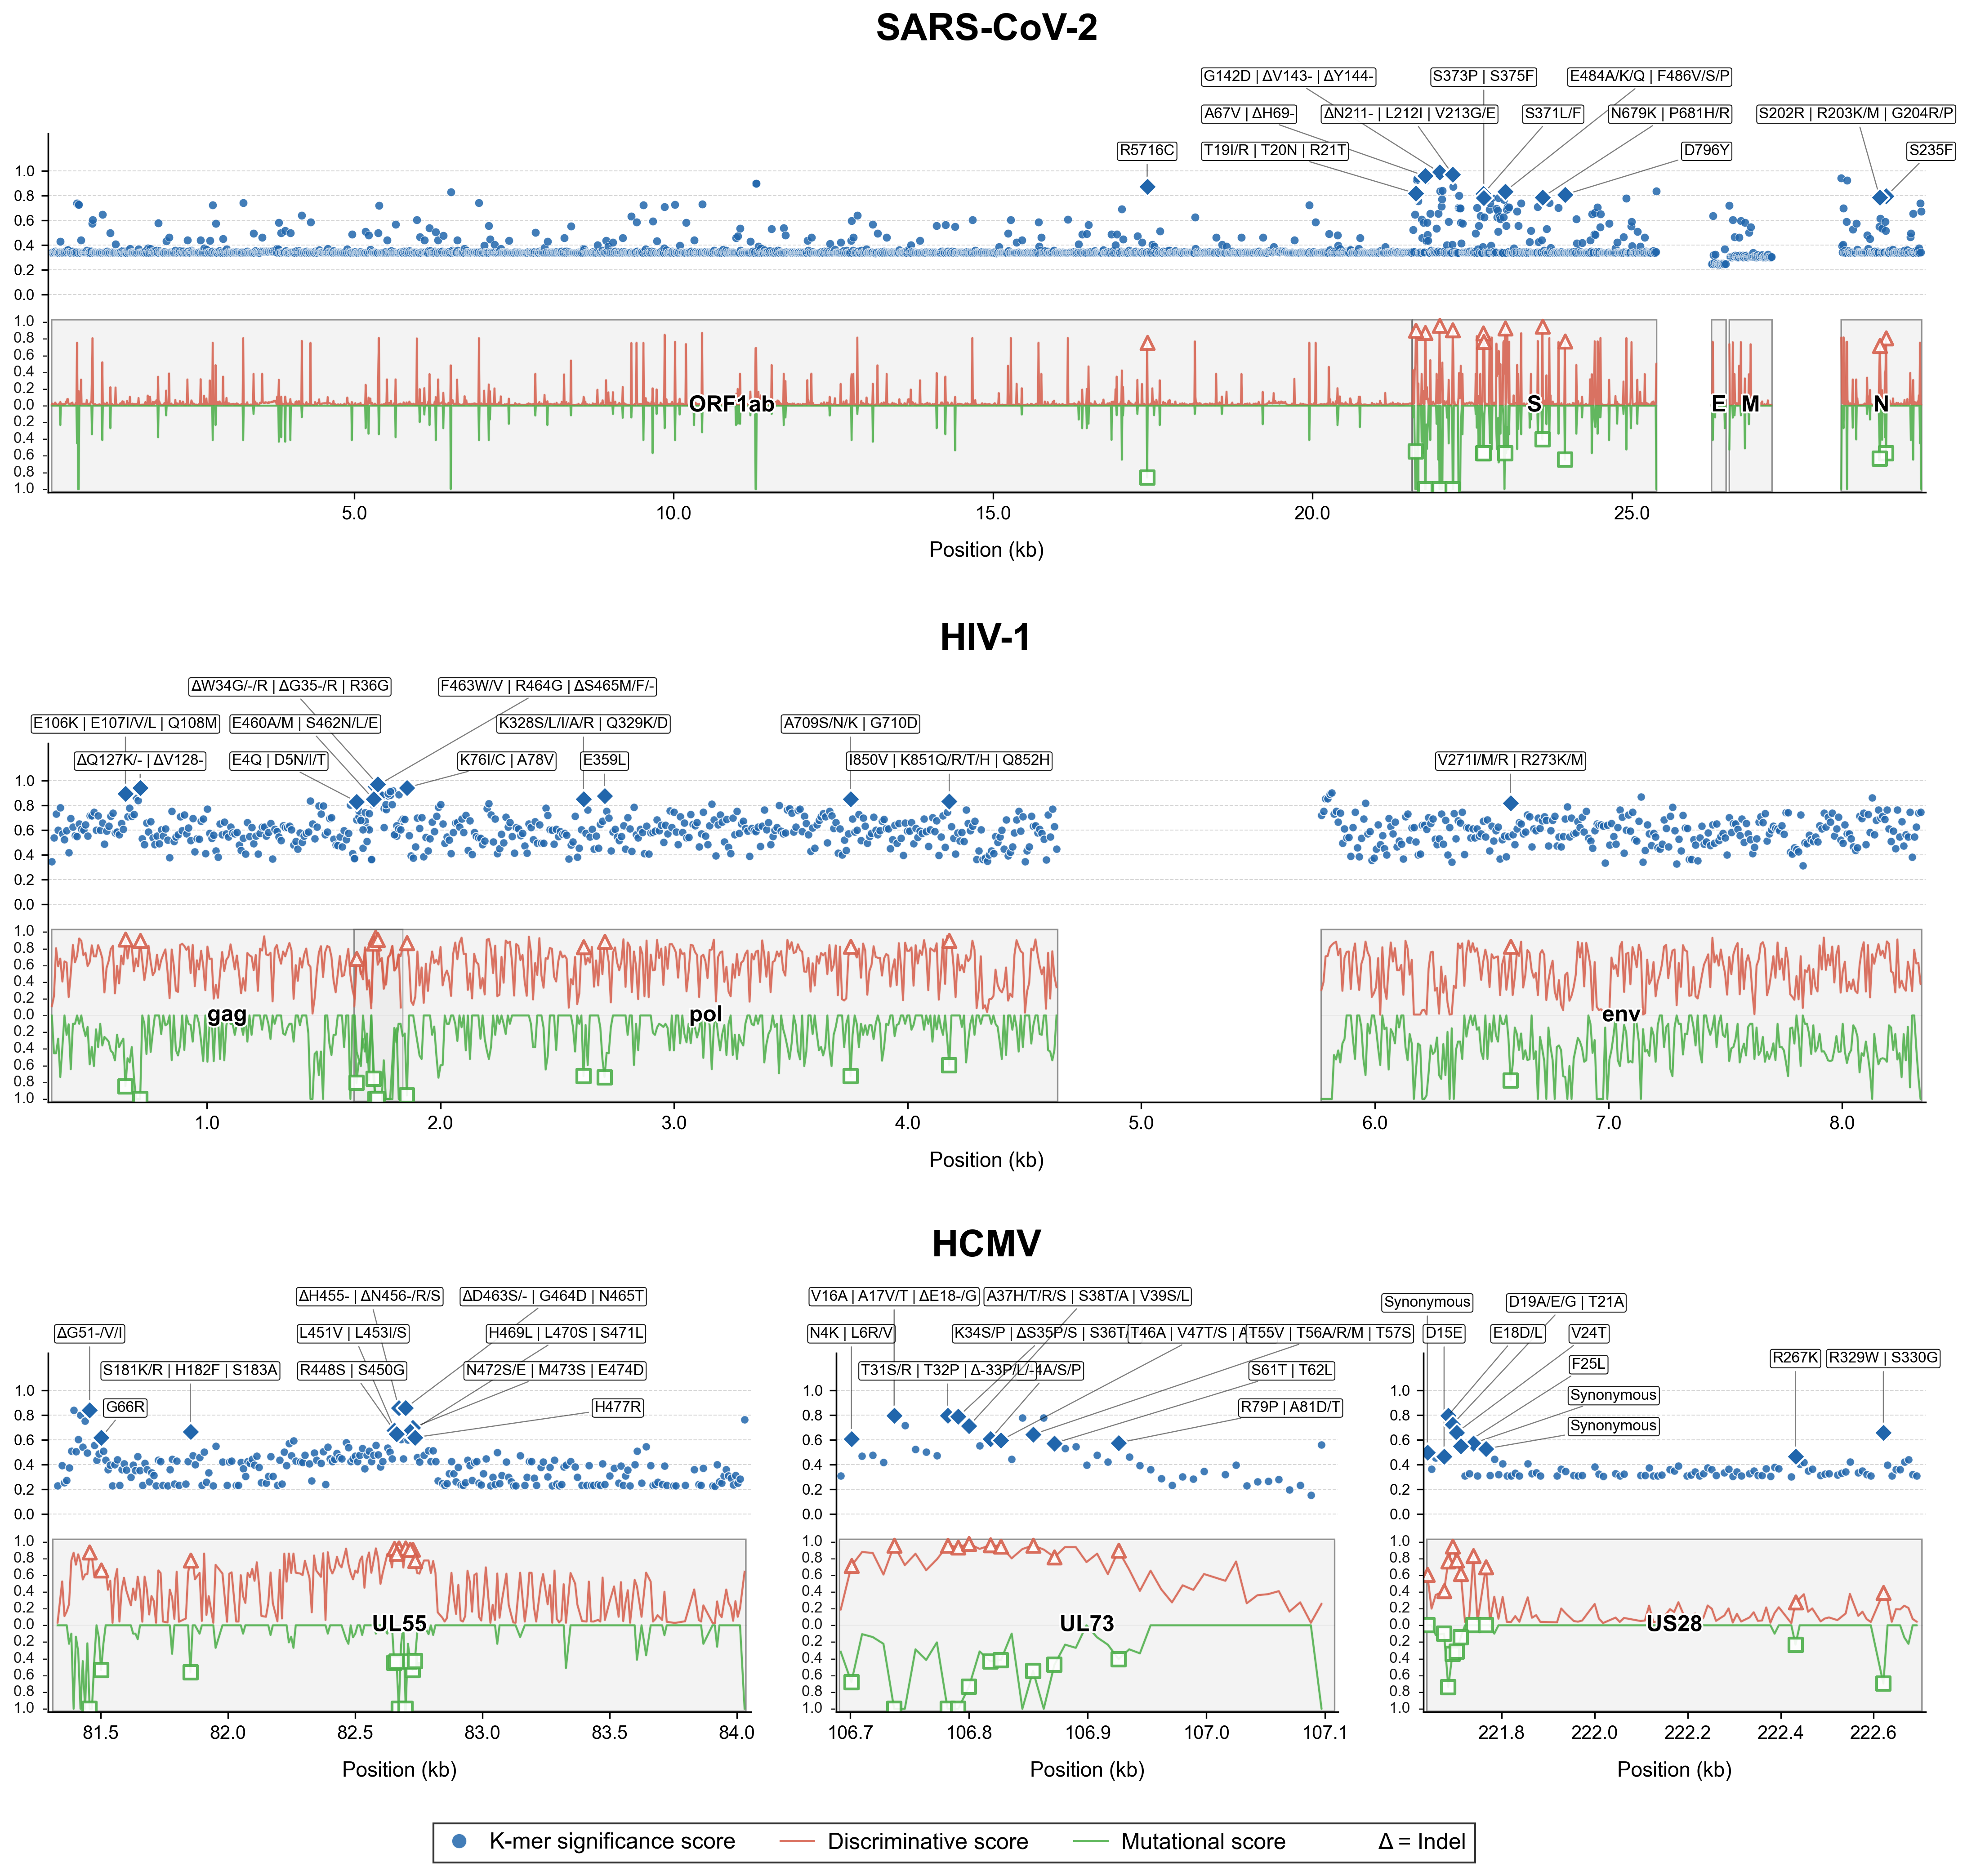

Figure generated successfully!


In [ ]:
if viral_data:
    print("Generating publication figure...")
    fig = generate_publication_figure(viral_data)
    plt.show()
    print("Figure generated successfully!")

In [ ]:
# Load all viral data
print("=" * 80)
print("Loading viral data...")
print("=" * 80)

viral_data = load_all_viral_data()

if not viral_data:
    print("Error: No data loaded. Please check data paths.")
else:
    print(f"\nSuccessfully loaded data for {len(viral_data)} viruses")

Loading viral data...

Loading data for SARS-CoV-2...
Configuration: Top N = 12, Max Indels = 3

   Processing gene: ORF1ab
   Loading compiled results for ORF1ab... ✓ (0.01s)
  Found CDS for ORF1ab: positions 265..21555
   Processing 2366 positions... ✓ (0.00s)
   Extracting top 10000 positions for ORF1ab... 

TypeError: format_class_distribution() got an unexpected keyword argument 'min_percentage'

## 11. Export Figure

In [ ]:
output_dir = "publication_figures"
os.makedirs(output_dir, exist_ok=True)

# High-resolution PDF
pdf_path = os.path.join(output_dir, "KSS_figure_dynamic.pdf")
fig.savefig(pdf_path, dpi=StyleConfig.EXPORT_DPI, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Saved: {pdf_path}")

# PNG for quick viewing
png_path = os.path.join(output_dir, "KSS_figure_dynamic.png")
fig.savefig(png_path, dpi=StyleConfig.FIGURE_DPI, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Saved: {png_path}")

Saved: publication_figures\KSS_figure_dynamic.pdf
Saved: publication_figures\KSS_figure_dynamic.png


## Generate Supplementary Tables S3-S5

  Export top-ranking positions and per-gene indel statistics as multi-sheet Excel files (.xlsx).
  - **S3**: SARS-CoV-2 top 10 genome-wide positions
  - **S4**: HIV-1 top 10 genome-wide positions
  - **S5**: HCMV top 10 per-gene positions (UL55, UL73, US28)

  Each file contains two sheets:
  - **Sheet 1 (Top Positions)**: One row per variant k-mer with component scores, amino acid changes, and variant/lineage distribution.
  - **Sheet 2 (Indel Statistics)**: Per-gene counts of positions with indels.

In [ ]:
def clean_label(label):
    """Remove LaTeX formatting from mutation labels."""
    return re.sub(r'\$\\mathbf\{\\Delta\}\$', '', label).strip()


def get_indel_stats(compiled_results):
    """Compute indel statistics from all positions in compiled results."""
    total = 0
    with_indels = 0
    for pos_key, pos_data in compiled_results.items():
        if not isinstance(pos_data, dict) or "alts" not in pos_data:
            continue
        total += 1
        for alt_info in pos_data["alts"].values():
            if any("-" in ch for ch in alt_info.get("amino_acid_changes", {})):
                with_indels += 1
                break
    return total, with_indels


def format_mutations(aa_changes_dict):
    """Format amino acid changes dict into readable string with consistent decimals."""
    parts = []
    for change, score in sorted(aa_changes_dict.items(), key=lambda x: x[1], reverse=True):
        parts.append(f"{change} ({score:.3f})")
    return "; ".join(parts) if parts else "Synonymous"


def format_class_distribution(class_counts, max_show=100):
    """Format class distribution as readable string."""
    total = sum(class_counts.values())
    if total == 0:
        return ""
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    parts = []
    for cls, count in sorted_classes[:max_show]:
        pct = count / total * 100
        if pct >= 1.0:
            parts.append(f"{cls} ({pct:.1f}%)")
    remaining = len(sorted_classes) - len(parts)
    if remaining > 0:
        parts.append(f"+{remaining} others")
    return ", ".join(parts)

def build_position_rows(viral_data, virus_key, genes, mode="genome-wide"):
    """Build expanded rows: one row per variant k-mer per top position."""
    rows = []

    if mode == "genome-wide":
        all_top = []
        for gene in genes:
            for pos in viral_data[virus_key][gene]["top_positions"]:
                all_top.append((gene, pos))
        all_top.sort(key=lambda x: x[1]["kss"], reverse=True)
        positions_list = [(rank, gene, pos) for rank, (gene, pos) in enumerate(all_top, 1)]
    else:
        positions_list = []
        for gene in genes:
            for rank, pos in enumerate(viral_data[virus_key][gene]["top_positions"], 1):
                positions_list.append((rank, gene, pos))

    for rank, gene, pos in positions_list:
        raw_data = pos.get("raw_data", {})
        alts = raw_data.get("alts", {})
        ref_kmer = pos["ref"]
        n_variants = max(len(alts), 1)

        if alts:
            for i, (alt_seq, alt_info) in enumerate(alts.items()):
                aa_changes = alt_info.get("amino_acid_changes", {})
                class_counts = alt_info.get("class_counts", {})
                has_indel = any("-" in ch for ch in aa_changes)
                rows.append({
                    "Rank": rank if i == 0 else "",
                    "Gene": gene if i == 0 else "",
                    "Gene Position": pos["gene_position"] if i == 0 else "",
                    "KSS": f"{pos['kss']:.3f}" if i == 0 else "",
                    "Discriminative": f"{pos['discriminative_score']:.3f}" if i == 0 else "",
                    "Mutational": f"{pos['mutational_score']:.3f}" if i == 0 else "",
                    "Protein": f"{pos['protein_score']:.3f}" if i == 0 else "",
                    "Ref K-mer": ref_kmer if i == 0 else "",
                    "Variant K-mer": alt_seq,
                    "Amino Acid Changes": format_mutations(aa_changes),
                    "Indel": has_indel,
                    "Variant Distribution": format_class_distribution(class_counts),
                    "_rank": rank,  # for grouping
                    "_n_variants": n_variants,
                })
        else:
            rows.append({
                "Rank": rank,
                "Gene": gene,
                "Gene Position": pos["gene_position"],
                "KSS": f"{pos['kss']:.3f}",
                "Discriminative": f"{pos['discriminative_score']:.3f}",
                "Mutational": f"{pos['mutational_score']:.3f}",
                "Protein": f"{pos['protein_score']:.3f}",
                "Ref K-mer": ref_kmer,
                "Variant K-mer": "",
                "Amino Acid Changes": clean_label(pos["label"]),
                "Indel": pos["has_indel"],
                "Variant Distribution": "",
                "_rank": rank,
                "_n_variants": 1,
            })

    return rows


def build_indel_rows(viral_data, virus_key, genes):
    """Build indel statistics rows."""
    rows = []
    for gene in genes:
        total, with_indels = get_indel_stats(
            viral_data[virus_key][gene]["compiled_results"]
        )
        without = total - with_indels
        pct = round(with_indels / total * 100, 1) if total > 0 else 0.0
        rows.append({
            "Gene": gene,
            "Total Positions Analyzed": total,
            "Positions With Indels": with_indels,
            "Positions Without Indels": without,
            "Indel Percentage (%)": f"{pct:.1f}",
        })
    return rows


def write_xlsx(filename, position_rows, indel_rows, title):
    """Write a two-sheet Excel file with formatting."""
    wb = Workbook()

    # --- Sheet 1: Top Positions ---
    ws1 = wb.active
    ws1.title = "Top Positions"

    cols = ["Rank", "Gene", "Gene Position", "KSS", "Discriminative",
            "Mutational", "Protein", "Ref K-mer", "Variant K-mer",
            "Amino Acid Changes", "Indel", "Variant Distribution"]

    header_font = Font(bold=True)
    header_fill = PatternFill(start_color="D9E1F2", end_color="D9E1F2", fill_type="solid")
    thin_border = Border(
        left=Side(style='thin'), right=Side(style='thin'),
        top=Side(style='thin'), bottom=Side(style='thin')
    )

    # Headers
    for col_idx, col_name in enumerate(cols, 1):
        cell = ws1.cell(row=1, column=col_idx, value=col_name)
        cell.font = header_font
        cell.fill = header_fill
        cell.border = thin_border
        cell.alignment = Alignment(horizontal='center', wrap_text=True)

    # Data
    for row_idx, row_data in enumerate(position_rows, 2):
        for col_idx, col_name in enumerate(cols, 1):
            val = row_data.get(col_name, "")
            cell = ws1.cell(row=row_idx, column=col_idx, value=val)
            cell.border = thin_border
            if col_name in ("KSS", "Discriminative", "Mutational", "Protein"):
                cell.alignment = Alignment(horizontal='center')
            elif col_name == "Rank":
                cell.alignment = Alignment(horizontal='center', vertical='center')

    # Merge cells for multi-variant positions (Rank, Gene, Gene Position, scores, Ref K-mer)
    merge_cols = [1, 2, 3, 4, 5, 6, 7, 8]  # columns to merge
    row_idx = 2
    while row_idx <= len(position_rows) + 1:
        n_variants = position_rows[row_idx - 2].get("_n_variants", 1)
        if n_variants > 1:
            for col in merge_cols:
                ws1.merge_cells(
                    start_row=row_idx, start_column=col,
                    end_row=row_idx + n_variants - 1, end_column=col
                )
                ws1.cell(row=row_idx, column=col).alignment = Alignment(
                    horizontal='center', vertical='center', wrap_text=True
                )
        row_idx += n_variants

    # Column widths
    col_widths = [6, 8, 12, 7, 12, 10, 8, 14, 14, 30, 6, 35]
    for i, w in enumerate(col_widths, 1):
        ws1.column_dimensions[get_column_letter(i)].width = w

    # --- Sheet 2: Indel Statistics ---
    ws2 = wb.create_sheet("Indel Statistics")

    indel_cols = ["Gene", "Total Positions Analyzed", "Positions With Indels",
                "Positions Without Indels", "Indel Percentage (%)"]

    for col_idx, col_name in enumerate(indel_cols, 1):
        cell = ws2.cell(row=1, column=col_idx, value=col_name)
        cell.font = header_font
        cell.fill = header_fill
        cell.border = thin_border
        cell.alignment = Alignment(horizontal='center', wrap_text=True)

    for row_idx, row_data in enumerate(indel_rows, 2):
        for col_idx, col_name in enumerate(indel_cols, 1):
            val = row_data.get(col_name, "")
            cell = ws2.cell(row=row_idx, column=col_idx, value=val)
            cell.border = thin_border
            cell.alignment = Alignment(horizontal='center')

    for i, w in enumerate([10, 22, 20, 22, 18], 1):
        ws2.column_dimensions[get_column_letter(i)].width = w

    wb.save(filename)
    print(f"  Saved: {filename}")


# ============================================================
# Generate S3: SARS-CoV-2
# ============================================================
sars_key = "Severe_acute_respiratory_syndrome_coronavirus_2"
sars_genes = ["ORF1ab", "S", "M", "N", "E"]
pos_rows = build_position_rows(viral_data, sars_key, sars_genes, mode="genome-wide")
indel_rows = build_indel_rows(viral_data, sars_key, sars_genes)
write_xlsx("S3_Table.xlsx", pos_rows, indel_rows, "SARS-CoV-2")
print(f"  {len(pos_rows)} position rows, {len(indel_rows)} gene indel stats")

# ============================================================
# Generate S4: HIV-1
# ============================================================
hiv_key = "Human_immunodeficiency_virus_1"
hiv_genes = ["gag", "pol", "env"]
pos_rows = build_position_rows(viral_data, hiv_key, hiv_genes, mode="genome-wide")
indel_rows = build_indel_rows(viral_data, hiv_key, hiv_genes)
write_xlsx("S4_Table.xlsx", pos_rows, indel_rows, "HIV-1")
print(f"  {len(pos_rows)} position rows, {len(indel_rows)} gene indel stats")

# ============================================================
# Generate S5: HCMV
# ============================================================
hcmv_key = "Human_betaherpesvirus_5"
hcmv_genes = ["UL55", "UL73", "US28"]
pos_rows = build_position_rows(viral_data, hcmv_key, hcmv_genes, mode="per-gene")
indel_rows = build_indel_rows(viral_data, hcmv_key, hcmv_genes)
write_xlsx("S5_Table.xlsx", pos_rows, indel_rows, "HCMV")
print(f"  {len(pos_rows)} position rows, {len(indel_rows)} gene indel stats")

  Saved: S3_Table.xlsx
  48 position rows, 5 gene indel stats
  Saved: S4_Table.xlsx
  85 position rows, 3 gene indel stats
  Saved: S5_Table.xlsx
  136 position rows, 3 gene indel stats
